In [1]:
import icechunk
import matplotlib.pyplot as plt

from ocr import catalog, load_structures_destroyed
from ocr.utils import convert_coords, interpolate_to_30, lon_to_180, subset_region_xy
from ocr.wind import (
    apply_mode_calc,
    apply_wind_directional_convolution,
    classify_wind_directions,
    create_composite_bp_map,
    create_finescale_wind_direction,
)

In [2]:
# Load in 270m risk

In [3]:
riley = {}
riley['2011'] = catalog.get_dataset('2011-climate-run').to_xarray()
riley['2047'] = catalog.get_dataset('2047-climate-run').to_xarray()

In [4]:
structures = load_structures_destroyed(fire_name='Eaton', target_crs='EPSG:5070')

In [5]:
buffer = 20000
x_min, x_max = structures.geometry.x.min() - buffer, structures.geometry.x.max() + buffer
y_min, y_max = structures.geometry.y.min() - buffer, structures.geometry.y.max() + buffer

In [6]:
subset = subset_region_xy(riley['2011'], [x_min, x_max], [y_min, y_max])

In [7]:
[(lon_min, lat_max), (lon_max, lat_min)] = convert_coords(
    [(x_min, y_max), (x_max, y_min)], from_crs='EPSG:5070', to_crs='EPSG:4326'
)

In [8]:
# expand the lats a smidge to make sure lat and lon dim lengths are both >1. it fails if dim length is 1. fixing this corner-case is low-priority.
lat_max += 0.2
lat_min -= 0.2
lon_max += 0.15
lon_min -= 0.15

In [9]:
lat_min, lat_max

(33.83876542382757, 34.547165362701236)

In [10]:
lon_min, lon_max

(-118.58257440430289, -117.60416825093)

In [11]:
# load in the 30m product as a template
# Note: This does not have dask chunks!
rps_30 = catalog.get_dataset('USFS-wildfire-risk-communities').to_xarray()

In [12]:
rps_30 = subset_region_xy(rps_30, [x_min, x_max], [y_min, y_max])

In [13]:
rps_30

<xarray.Dataset> Size: 156MB
Dimensions:      (y: 1595, x: 1748)
Coordinates:
  * x            (x) float64 14kB -2.029e+06 -2.029e+06 ... -1.976e+06
  * y            (y) float64 13kB 1.494e+06 1.494e+06 ... 1.447e+06 1.447e+06
Data variables:
    CRPS         (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    BP           (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    Exposure     (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    CFL          (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    WHP          (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    FLEP4        (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>
    spatial_ref  int64 8B ...
    FLEP8        (y, x) float64 22MB dask.array<chunksize=(898, 1748), meta=np.ndarray>

In [14]:
subset_30 = interpolate_to_30(subset, rps_30)

In [15]:
subset_30

<xarray.Dataset> Size: 156MB
Dimensions:      (y: 1595, x: 1748)
Coordinates:
  * y            (y) float64 13kB 1.494e+06 1.494e+06 ... 1.447e+06 1.447e+06
  * x            (x) float64 14kB -2.029e+06 -2.029e+06 ... -1.976e+06
Data variables:
    FLP1         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    FLP3         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    FLP2         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    BP           (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    FLP6         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    FLP4         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>
    spatial_ref  int64 8B ...
    FLP5         (y, x) float64 22MB dask.array<chunksize=(1595, 1748), meta=np.ndarray>

In [16]:
subset_30 = subset_30.rio.write_crs('EPSG:5070')

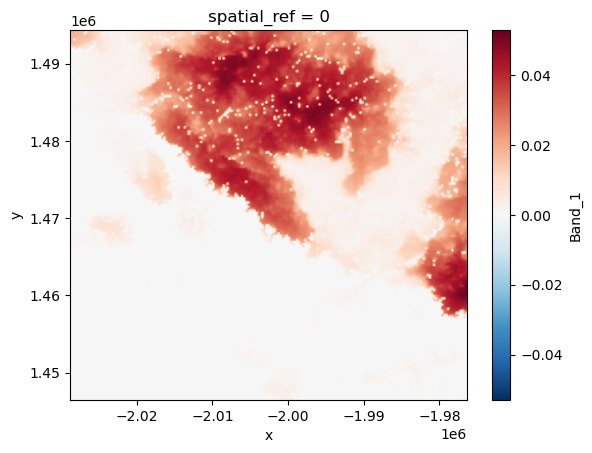

In [17]:
subset_30.BP.plot()

In [18]:
# reprojecting introduces a lot of nans which presents two TODOs
# (1) the convolution doesn't handle nans (at least presently). fill those with -9999s for now.
# TODO: this is an imperfect solution we want to fix to limit errors down the road. the
# (2) the reprojection decreases the useable data, meaning that we need to increase the buffer
# that we clip around the edges of the data tile
subset_30 = subset_30.rio.reproject('EPSG:4326').fillna(-9999)

In [19]:
subset_30

<xarray.Dataset> Size: 201MB
Dimensions:      (y: 1666, x: 2154)
Coordinates:
  * x            (x) float64 17kB -118.4 -118.4 -118.4 ... -117.8 -117.8 -117.8
  * y            (y) float64 13kB 34.46 34.46 34.45 34.45 ... 33.93 33.93 33.93
    spatial_ref  int64 8B 0
Data variables:
    FLP1         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    FLP3         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    FLP2         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    BP           (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    FLP6         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    FLP4         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03
    FLP5         (y, x) float64 29MB -9.999e+03 -9.999e+03 ... -9.999e+03

In [20]:
# Create a BP map smeared according to each of the 8 cardinal and intercardinal directions

In [21]:
blurred_bp = apply_wind_directional_convolution(subset_30['BP'], iterations=3)

In [22]:
# Load in the dataset of wind for fire weather days

In [23]:
important_days = catalog.get_dataset('era5-fire-weather-days').to_xarray()

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f124e91b890>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f12276857f0>, 866.025784392)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f124e91b4d0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f1227638190>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f1227685d30>, 866.028764896)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f122776d810>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f1227786710>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7f1227685f70>, 866.039472381)])']
connector: <aiohttp.connector.TCPConnector object at 0x7f1227786350>


In [24]:
important_days = lon_to_180(important_days)

In [25]:
subset_wind = important_days.sel(
    latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)
)
wind_directions = subset_wind['sfcWindfromdir']

In [26]:
# we only have to do the wind direction classification once - want to get the distribution of each direction. prep this and store it like `fire_weather_days_v2.zarr`

In [27]:
direction_indices = classify_wind_directions(wind_directions).chunk(dict(time=-1))

In [28]:
direction_modes = apply_mode_calc(direction_indices).compute()

In [29]:
direction_modes_reprojected = create_finescale_wind_direction(blurred_bp, direction_modes)

In [30]:
wind_informed_bp = create_composite_bp_map(blurred_bp, direction_modes_reprojected)

In [31]:
# load in the crps because we'll use it as the template to register the BP to

In [32]:
crps = rps_30['CRPS'].rio.write_crs('EPSG:5070')
crps.rio.crs

CRS.from_wkt('PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]')

In [33]:
subset_crps = crps.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

In [34]:
wind_informed_bp = wind_informed_bp.rio.reproject_match(subset_crps)

In [35]:
wind_informed_bp

<xarray.DataArray (y: 1595, x: 1748)> Size: 22MB
array([[-4311.90470411, -4318.83374995, -4631.45450241, ...,
        -5430.77913936, -5349.45082139, -5269.73995021],
       [-4020.06715097, -4318.83374995, -4325.11176004, ...,
        -5413.78381802, -5332.66833189, -5253.17623156],
       [-4026.95230249, -4033.18169817, -4038.84894887, ...,
        -5363.09160162, -5203.76165456, -5126.76194177],
       ...,
       [-9651.59866116, -9612.55498853, -9570.58601645, ...,
        -1699.8070057 , -1731.00762363, -1760.55269694],
       [-9653.71410272, -9614.85073999, -9573.07277579, ...,
        -1935.56761987, -1968.98946611, -2000.62414996],
       [-9654.42210271, -9615.61953054, -9573.07277579, ...,
        -2190.59248904, -2226.19419798, -2259.87637467]],
      shape=(1595, 1748))
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 14kB -2.029e+06 -2.029e+06 ... -1.976e+06
  * y            (y) float64 13kB 1.494e+06 1.494e+06 ... 1.447e+06 1.447e+06
Attributes:
    _FillValue:  nan

In [36]:
# TODO: decide how big of a buffer to trim it down. the size of the kernel plus a little to play it safe?

In [37]:
wind_informed_bp = wind_informed_bp.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

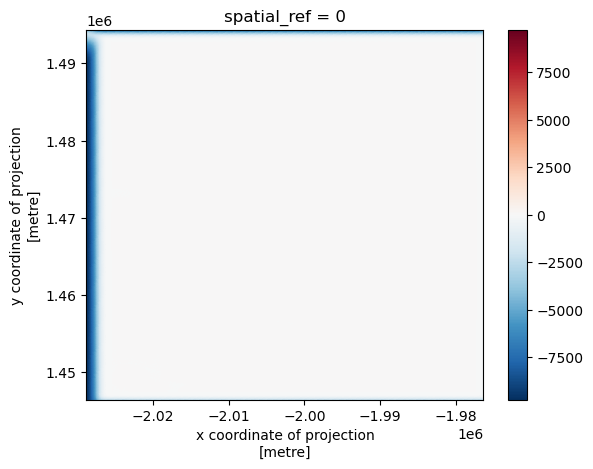

In [38]:
wind_informed_bp.plot()

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

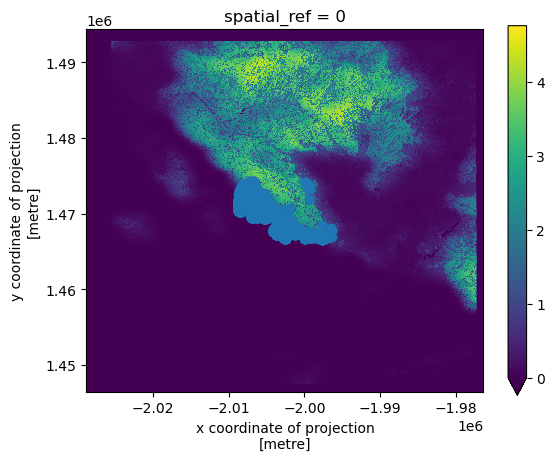

In [39]:
fig, ax = plt.subplots()
(wind_informed_bp * subset_crps).plot(ax=ax, vmin=0)
structures.plot(ax=ax)

In [40]:
wind_informed_bp

<xarray.DataArray (y: 1595, x: 1748)> Size: 22MB
array([[-4311.90470411, -4318.83374995, -4631.45450241, ...,
        -5430.77913936, -5349.45082139, -5269.73995021],
       [-4020.06715097, -4318.83374995, -4325.11176004, ...,
        -5413.78381802, -5332.66833189, -5253.17623156],
       [-4026.95230249, -4033.18169817, -4038.84894887, ...,
        -5363.09160162, -5203.76165456, -5126.76194177],
       ...,
       [-9651.59866116, -9612.55498853, -9570.58601645, ...,
        -1699.8070057 , -1731.00762363, -1760.55269694],
       [-9653.71410272, -9614.85073999, -9573.07277579, ...,
        -1935.56761987, -1968.98946611, -2000.62414996],
       [-9654.42210271, -9615.61953054, -9573.07277579, ...,
        -2190.59248904, -2226.19419798, -2259.87637467]],
      shape=(1595, 1748))
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 14kB -2.029e+06 -2.029e+06 ... -1.976e+06
  * y            (y) float64 13kB 1.494e+06 1.494e+06 ... 1.447e+06 1.447e+06
Attributes:
    _FillValue:  nan

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

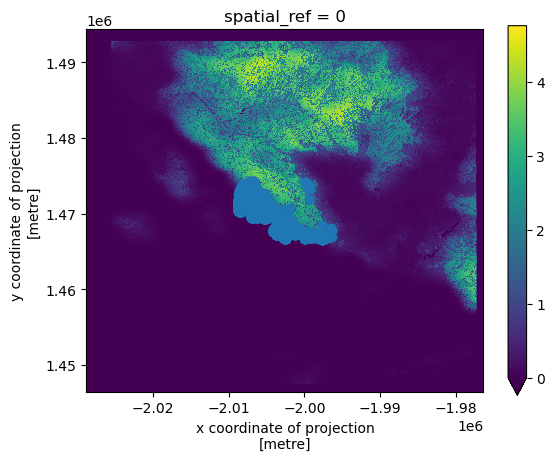

In [41]:
fig, ax = plt.subplots()
(wind_informed_bp * subset_crps).plot(vmin=0)
structures.plot(ax=ax)

In [42]:
risk = (wind_informed_bp * subset_crps).to_dataset(name='risk')

## Write


In [46]:
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr', prefix='intermediates/fire-risk/tensor/bp-icechunk'
)
repo = icechunk.Repository.open_or_create(storage=storage)
session = repo.writable_session('main')
wind_informed_bp.to_dataset(name='BP').to_zarr(session.store, consolidated=False, mode='w')
session.commit('writing BP intermediate to icechunk')

'Y6PHZF9VYRD2D9AVH7Z0'

In [48]:
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr', prefix='intermediates/fire-risk/tensor/risk-icechunk'
)
repo = icechunk.Repository.open_or_create(storage=storage)
session = repo.writable_session('main')
risk.where(risk > 0, 0).to_zarr(session.store, consolidated=False)
session.commit('writing risk intermediate icechunk')

'NVKWSG1AM1VWT1F5D7SG'